# In this notebook we will explore feature extraction with a Vision Transformer [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224), we will explore the architecture of the model, inputs/outputs and finally we will reproduce similar experiments as the [sklearn_notebook](experiments/sklearn_exploration.ipynb)

## Model Overview

In [54]:
from transformers import AutoModel, AutoFeatureExtractor
import warnings
import torch
from torchinfo import summary # type: ignore
import pandas as pd
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL.PngImagePlugin import PngImageFile
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
from typing import List, Tuple, Optional, Any, Dict
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../data/img"

### The `FeatureExtractor` is equivalent to the `Tokenizer`for NLP Transformers, it will apply modifications to the images, transform them into tensors so that they can pass into the model

In [3]:
model_ckpt = "google/vit-base-patch16-224"

model = AutoModel.from_pretrained(model_ckpt)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## We can see which model has an architecture similar to `BERT`, (except at the level of the embeddings layer where here we patch then flatten)

In [4]:
print(model)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [5]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViTModel                                           [1, 768]                  --
├─ViTEmbeddings: 1-1                               [1, 197, 768]             152,064
│    └─ViTPatchEmbeddings: 2-1                     [1, 196, 768]             --
│    │    └─Conv2d: 3-1                            [1, 768, 14, 14]          590,592
│    └─Dropout: 2-2                                [1, 197, 768]             --
├─ViTEncoder: 1-2                                  [1, 197, 768]             --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ViTLayer: 3-2                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-3                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-4                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-5                          [1, 197, 768]             7,087,8

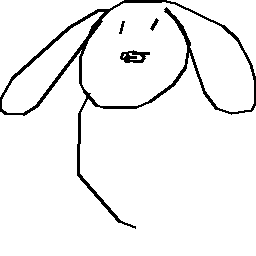

In [6]:
image = Image.open(f"{DATA_PATH}/train/dog/20.png")
image

In [7]:
inputs = feature_extractor(images=image, return_tensors="pt")

In [8]:
print(inputs.keys())

dict_keys(['pixel_values'])


### The input shape is:  
#### - N: *number of batch*  
#### - C: *number of channels*
#### - H: *height*
#### - W: *width*

In [9]:
print(inputs["pixel_values"].shape)

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


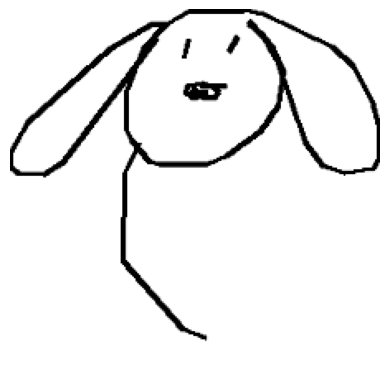

In [10]:
import matplotlib.pyplot as plt
plt.imshow(inputs["pixel_values"][0].permute(1, 2, 0))
plt.axis("off")
plt.show()

In [11]:
model.eval()
with torch.inference_mode():
    outputs = model(**inputs)

In [12]:
print(outputs)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 6.6221e-01,  9.9122e-01, -1.1790e-01,  ..., -3.9176e-02,
          -5.3824e-01,  7.1715e-01],
         [ 2.1505e-01,  1.8365e+00, -1.9912e-01,  ..., -1.5313e-01,
          -1.1370e-01,  6.1589e-01],
         [-7.8336e-01,  1.8182e+00, -5.2754e-01,  ...,  2.4913e-01,
          -4.8410e-01,  8.0221e-01],
         ...,
         [-7.7165e-02,  2.8163e-02, -5.1583e-04,  ...,  6.0855e-02,
          -8.4442e-02, -3.2627e-02],
         [-1.5608e-01,  1.3199e+00,  2.9173e-01,  ...,  2.4739e-01,
          -1.4852e-01,  6.1551e-01],
         [ 7.4800e-01,  1.6691e+00, -6.6095e-02,  ...,  4.9169e-01,
           2.9640e-01, -1.3714e-01]]]), pooler_output=tensor([[ 1.3888e-02, -4.0085e-01, -7.2168e-01,  6.3113e-02, -4.0806e-02,
          3.7321e-01, -8.0622e-01, -4.3150e-02,  7.4252e-02, -1.4722e-01,
          7.2108e-01,  4.3292e-01, -5.7219e-01, -7.5687e-01, -3.9645e-03,
         -5.0247e-01, -1.3431e-02, -8.0759e-01, -2.4448e-01,  1.2138e-01

In [13]:
print(outputs.keys())

odict_keys(['last_hidden_state', 'pooler_output'])


### The output shape is:  
#### - N: *number of batch*  
#### - C: *number of patches*
#### - E: *embedding size*

In [14]:
print(outputs['last_hidden_state'].shape)

torch.Size([1, 197, 768])


### Now we take the `[CLS]` token containing the global information of the image

In [15]:
print(outputs['pooler_output'].shape)

torch.Size([1, 768])


In [16]:
type(image)

PIL.PngImagePlugin.PngImageFile

In [17]:
def create_dataset(data_path: str) -> List[Tuple[PngImageFile, List[str]]]:
    classes = os.listdir(data_path)
    res = []
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)
            res.append((image, class_name))
    return res

In [18]:
dataset = create_dataset(f"{DATA_PATH}/train")

In [19]:
len(dataset)

3315

In [20]:
def get_data_set_pooler_output(dataset: List[Tuple[PngImageFile, str]], 
                               model: torch.nn.Module, 
                               feature_extractor: AutoFeatureExtractor) -> pd.DataFrame:
    
    dict = {"image": [], "label": [], "pooler_output": []}
    for image, label in tqdm(dataset, desc="Extracting pooler output from dataset", total=len(dataset)):
        inputs = feature_extractor(images=image, return_tensors="pt")
        with torch.inference_mode():
            outputs = model(**inputs)
        dict["image"].append(image)
        dict["label"].append(label)
        dict["pooler_output"].append(outputs['pooler_output'].detach().numpy())
    return pd.DataFrame(dict)

In [21]:
df_with_cls = get_data_set_pooler_output(dataset, model, feature_extractor)

Extracting pooler output from dataset:   0%|          | 0/3315 [00:00<?, ?it/s]

## 3D Vizualisation with `UMAP` and the `[CLS]` tokens

In [22]:
df_backup = df_with_cls.copy()

In [23]:
df_with_cls.head()

,image,label,pooler_output
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[0.15501721, 0.48910326, -0.14241835, -0.0733..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.13566609, 0.11032833, -0.20058215, -0.462..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.49262735, 0.26423675, -0.5138086, -0.0384..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.35330543, -0.011537397, -0.31844896, 0.33..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.07573275, 0.25735587, -0.1641229, -0.4706..."


In [24]:
df_with_cls = df_with_cls.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
df_with_cls.head()

,image,label,pooler_output
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,onion,"[[0.2084636, -0.15165232, -0.3166378, -0.34937..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,raccoon,"[[0.8177351, 0.22997841, 0.35691997, 0.1615186..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,dog,"[[0.06935201, 0.23611157, -0.041059732, 0.2220..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,watermelon,"[[0.1258831, 0.025164178, -0.70857435, -0.0200..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,table,"[[-0.75589204, 0.39867917, 0.20235355, -0.3514..."


In [29]:
df_with_cls["pooler_output"][0].shape

(1, 768)

In [31]:
processed_pooler_output = np.concatenate(df_with_cls["pooler_output"].values)
scaler = MinMaxScaler()
scaler.fit(processed_pooler_output)
processed_pooler_output = scaler.transform(processed_pooler_output)
print(processed_pooler_output.shape)

(3315, 768)


In [32]:
df_with_cls["pooler_output_minmax"] = [x for x in processed_pooler_output]

In [33]:
df_with_cls.head()

,image,label,pooler_output,pooler_output_minmax
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,onion,"[[0.2084636, -0.15165232, -0.3166378, -0.34937...","[0.60313094, 0.4071352, 0.34850913, 0.31021208..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,raccoon,"[[0.8177351, 0.22997841, 0.35691997, 0.1615186...","[0.9520689, 0.63912845, 0.7471243, 0.6029922, ..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,dog,"[[0.06935201, 0.23611157, -0.041059732, 0.2220...","[0.5234598, 0.64285684, 0.51159775, 0.6376549,..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,watermelon,"[[0.1258831, 0.025164178, -0.70857435, -0.0200...","[0.55583596, 0.5146219, 0.11655897, 0.49893415..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,table,"[[-0.75589204, 0.39867917, 0.20235355, -0.3514...","[0.050831378, 0.74168164, 0.6556511, 0.3090433..."


In [34]:
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_model.fit(processed_pooler_output)

UMAP(n_components=3, n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [35]:
df_with_cls["umap1"], df_with_cls["umap2"], df_with_cls["umap3"] = umap_model.embedding_[:, 0], umap_model.embedding_[:, 1], umap_model.embedding_[:, 2]

In [36]:
df_with_cls.head()

,image,label,pooler_output,pooler_output_minmax,umap1,umap2,umap3
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,onion,"[[0.2084636, -0.15165232, -0.3166378, -0.34937...","[0.60313094, 0.4071352, 0.34850913, 0.31021208...",6.451316,12.685045,2.060417
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,raccoon,"[[0.8177351, 0.22997841, 0.35691997, 0.1615186...","[0.9520689, 0.63912845, 0.7471243, 0.6029922, ...",6.589255,12.196106,0.293412
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,dog,"[[0.06935201, 0.23611157, -0.041059732, 0.2220...","[0.5234598, 0.64285684, 0.51159775, 0.6376549,...",6.544736,11.510583,-0.602584
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,watermelon,"[[0.1258831, 0.025164178, -0.70857435, -0.0200...","[0.55583596, 0.5146219, 0.11655897, 0.49893415...",4.767547,13.788085,1.575447
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,table,"[[-0.75589204, 0.39867917, 0.20235355, -0.3514...","[0.050831378, 0.74168164, 0.6556511, 0.3090433...",3.105701,9.948215,2.662694


In [38]:
import plotly.express as px
fig = px.scatter_3d(df_with_cls, x='umap1', y='umap2', z='umap3', color='label', title="3D Vizualization of Quick Draw dataset embeddings")

fig.show()

### Compared to the flattened representation observed with the `PCA` in the first notebook, we can distinguish clusters much better

## `KMeans` + `[CLS]` tokens

In [41]:
standardized_pooler_output = np.concatenate(df_with_cls["pooler_output"].values)
scaler = StandardScaler()
scaler.fit(standardized_pooler_output)
standardized_pooler_output = scaler.transform(standardized_pooler_output)
print(standardized_pooler_output.shape)

(3315, 768)


In [42]:
df_with_cls["pooler_output_standardized"] = [x for x in standardized_pooler_output]

In [43]:
kmeans = KMeans(n_clusters=len(df_with_cls["label"].unique()), random_state=42)
kmeans.fit(standardized_pooler_output)

KMeans(n_clusters=24, random_state=42)

In [44]:
df_with_cls["cluster"] = kmeans.labels_
df_with_cls.head()

,image,label,pooler_output,pooler_output_minmax,umap1,umap2,umap3,pooler_output_standardized,cluster
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,onion,"[[0.2084636, -0.15165232, -0.3166378, -0.34937...","[0.60313094, 0.4071352, 0.34850913, 0.31021208...",6.451316,12.685045,2.060417,"[0.5454781, -0.6717031, -0.36590114, -1.290104...",13
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,raccoon,"[[0.8177351, 0.22997841, 0.35691997, 0.1615186...","[0.9520689, 0.63912845, 0.7471243, 0.6029922, ...",6.589255,12.196106,0.293412,"[2.4520981, 0.566354, 1.7209063, 0.32580838, -...",5
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,dog,"[[0.06935201, 0.23611157, -0.041059732, 0.2220...","[0.5234598, 0.64285684, 0.51159775, 0.6376549,...",6.544736,11.510583,-0.602584,"[0.11015012, 0.58625066, 0.48789108, 0.5171187...",17
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,watermelon,"[[0.1258831, 0.025164178, -0.70857435, -0.0200...","[0.55583596, 0.5146219, 0.11655897, 0.49893415...",4.767547,13.788085,1.575447,"[0.28705534, -0.09808862, -1.5801935, -0.24850...",8
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,table,"[[-0.75589204, 0.39867917, 0.20235355, -0.3514...","[0.050831378, 0.74168164, 0.6556511, 0.3090433...",3.105701,9.948215,2.662694,"[-2.472322, 1.1136401, 1.2420307, -1.2965553, ...",4


In [46]:
def plot_cluster_distribution(data: pd.DataFrame,
                             kmeans: KMeans,
                             output: Optional[str] = None) -> pd.DataFrame:
        """
        plot the distribution of the labels in the clusters.
        @param {pd.DataFrame} data - data with the images and labels
        @param {KMeans} kmeans - kmeans model
        @param {str} output - path to save the image
        """
        df = data.copy()
        df['cluster'] = kmeans.labels_
        df = df.groupby(['cluster', 'label']).size().reset_index(name='count')
        
        px.defaults.template = "plotly_dark"
        fig = px.bar(df, x='cluster', y='count', color='label', barmode='relative')
        fig.show()
        if output:
            fig.write_image(output)

        return df

In [75]:
df_clustered = plot_cluster_distribution(df_with_cls, kmeans, "plots/cluster_distribution_vit.png")

### `GaussianNB`+ `[CLS]` tokens

In [49]:
gnb = GaussianNB()

gnb.fit(standardized_pooler_output, df_with_cls["label"])

GaussianNB()

In [50]:
DATA_TEST = f"{DATA_PATH}/test"

test_dataset = create_dataset(DATA_TEST)

In [51]:
len(test_dataset)

1100

In [52]:
df_test = get_data_set_pooler_output(test_dataset, model, feature_extractor)

Extracting pooler output from dataset:   0%|          | 0/1100 [00:00<?, ?it/s]

In [70]:
def compute_metrics(data: List[List[float]],
                    labels: List[str],
                    model: Any) -> Dict[str, float]:
    """
    compute the metrics for the model.
    @param {List[float]} embeddings
    @param {List[str]} labels - labels of the images
    @param {GaussianNB} model - model to evaluate
    @return {Dict[str, float]} - dictionary with the metrics
    """
    
    y_pred = model.predict(data)
    accuracy = accuracy_score(labels, y_pred)
    precision = precision_score(labels, y_pred, average='weighted')
    recall = recall_score(labels, y_pred, average='weighted')
    f1 = f1_score(labels, y_pred, average='weighted')
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

def display_confusion_matrix(data: List[List[float]],
                             labels: List[str],
                             model: Any,
                             output: Optional[str] = None) -> None:
    """
    display the confusion matrix for the model.
    @param {List[float]} data - data with the images and labels
    @param {GaussianNB} model - model to evaluate
    @param {str} output - path to save the image
    """
    
    y_pred = model.predict(data)
    y_true = labels
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    if output:
        plt.savefig(output)
    plt.show()

In [57]:
df_test["pooler_output_standardized"] = [x for x in scaler.transform(np.concatenate(df_test["pooler_output"].values))]

In [61]:
df_test.head()

,image,label,pooler_output,pooler_output_standardized
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.0026259362, -0.054669563, -0.60040337, -0...","[-0.1150936, -0.3570791, -1.2450596, -0.372171..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[0.5714281, 0.42404985, -0.1703757, 0.1341346...","[1.6813189, 1.1959456, 0.08724611, 0.23919545,..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[0.34677237, 0.108393684, -0.13542588, -0.398...","[0.9782938, 0.17191815, 0.19552718, -1.4457858..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.19896135, 0.28437245, -0.074731596, 0.079...","[-0.7294946, 0.7428149, 0.3835694, 0.065597504..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,ice cream,"[[-0.16574465, -0.16299152, -0.26604432, -0.14...","[-0.6255481, -0.7084889, -0.20915307, -0.64238..."


In [71]:
gnb_metrics = compute_metrics(df_test["pooler_output_standardized"].tolist(), df_test["label"], gnb)

In [72]:
gnb_metrics

{'accuracy': 0.7445454545454545,
 'precision': 0.7582166982269286,
 'recall': 0.7445454545454545,
 'f1': 0.745449358330257}

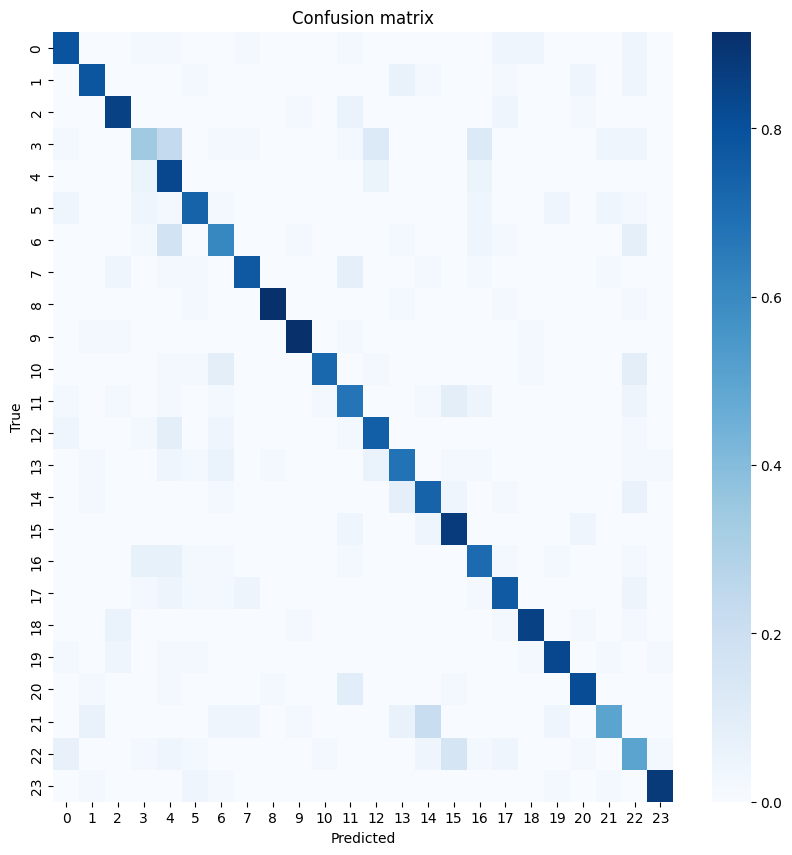

In [74]:
display_confusion_matrix(df_test["pooler_output_standardized"].tolist(), df_test["label"], gnb, "plots/confusion_matrix_vit_gnb.png")

## The metrics are quite good compared to ML models, and the confusion matrix is ​​very well structured, we see that `ViT` without fine tuning, with a simple classifier head is not bad. However we would still like to get closer to the original QuickDraw.